# Evaluation of the training with TT to Semileptonic files

## Confusion matrices, discriminator shapes, ROC curves

In [7]:
import uproot4 as uproot
import numpy as np
import awkward1 as ak

import matplotlib.pyplot as plt
import mplhep as hep

import torch
import torch.nn as nn

from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

import gc

import coffea.hist as hist


In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


#This is just some plot styling
plt.style.use(hep.cms.style.ROOT)
C = ['firebrick', 'darkgreen', 'darkblue', 'grey', 'cyan','magenta']
colorcode = ['firebrick','magenta','cyan','darkgreen']
path = 'Figures/'

In [15]:
test_input_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/test_inputs_%d.pt' % k for k in range(0,1)]


test_inputs = torch.cat(tuple(torch.load(ti) for ti in test_input_file_paths)).float()
print('test inputs done')
len_test = len(test_inputs)
print('number of test inputs', len_test)

test_target_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/test_targets_%d.pt' % k for k in range(0,1)]
DeepCSV_testset_file_paths = ['/work/um106329/new_march_21/scaledTTtoSemilep/DeepCSV_testset_%d.pt' % k for k in range(0,1)]

test_targets = torch.cat(tuple(torch.load(ti) for ti in test_target_file_paths)).float()
print('test targets done')
DeepCSV_testset = np.concatenate([torch.load(ti) for ti in DeepCSV_testset_file_paths])
print('DeepCSV test done')

test inputs done
number of test inputs 735127
test targets done
DeepCSV test done


In [283]:
at_epoch = 47
NUM_DATASETS = 1



criterion = nn.CrossEntropyLoss()



model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{at_epoch}_epochs_v10_GPU_weighted_wrs_{NUM_DATASETS}_datasets_TT.pt', map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

In [284]:
#evaluate network on inputs
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.numpy()
print('predictions done')

jetFlavour = test_targets+1

predictions done


In [285]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [286]:
mostprob = torch.argmax(predsTensor, 1)

In [287]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets, mostprob)
cfm

array([[170086,   5608,      0,  32344],
       [  1622,     82,      0,   1052],
       [ 61423,   1815,      0,   2959],
       [447217,   5402,      0,   5517]])

Text(0.5, 0.98, 'Classifier (WeightedRandomSampler) and DeepCSV outputs\n After 47 epochs, evaluated on 735127 jets')

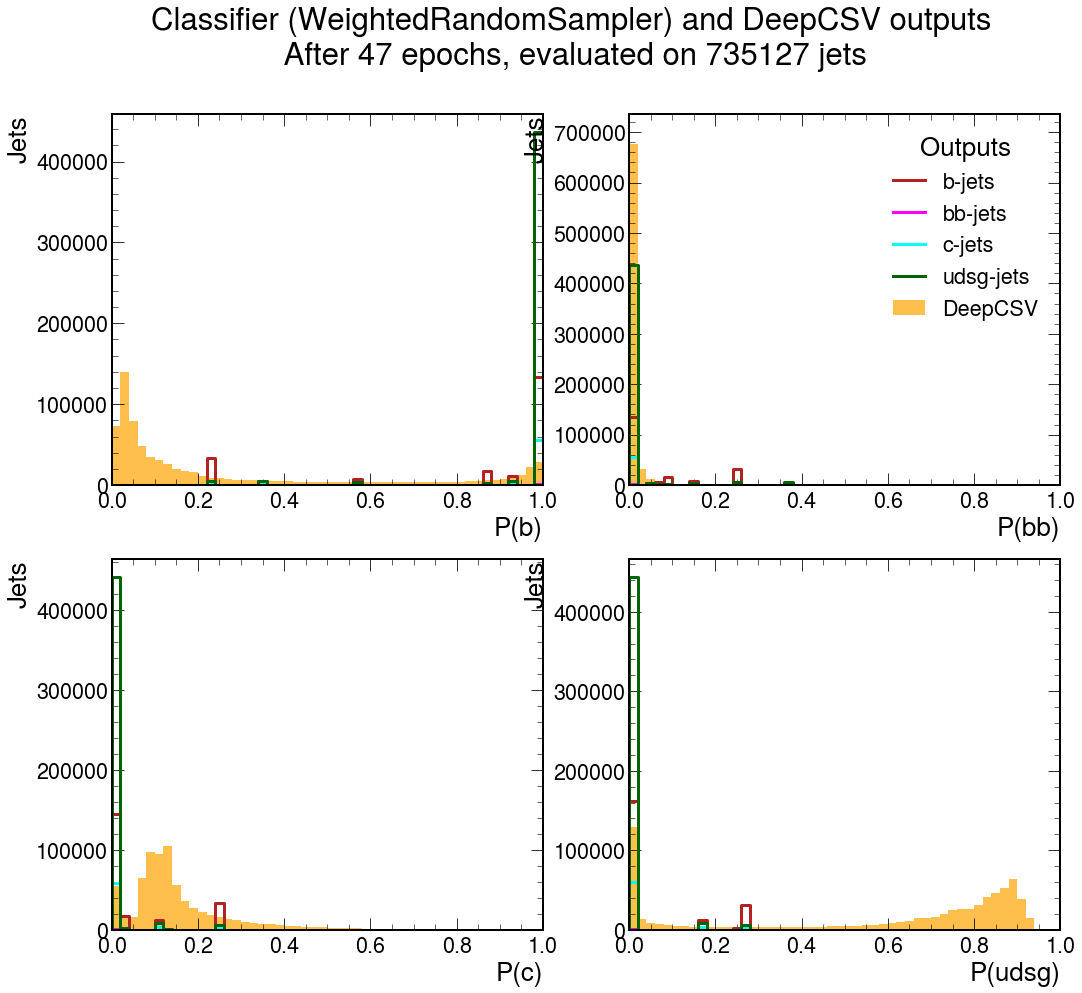

In [288]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (WeightedRandomSampler) and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.2271253498771028
auc for bb-tagging: 0.7840466870492263
auc for c-tagging: 0.5320834560419359
auc for udsg-tagging: 0.2501877038392157


22075

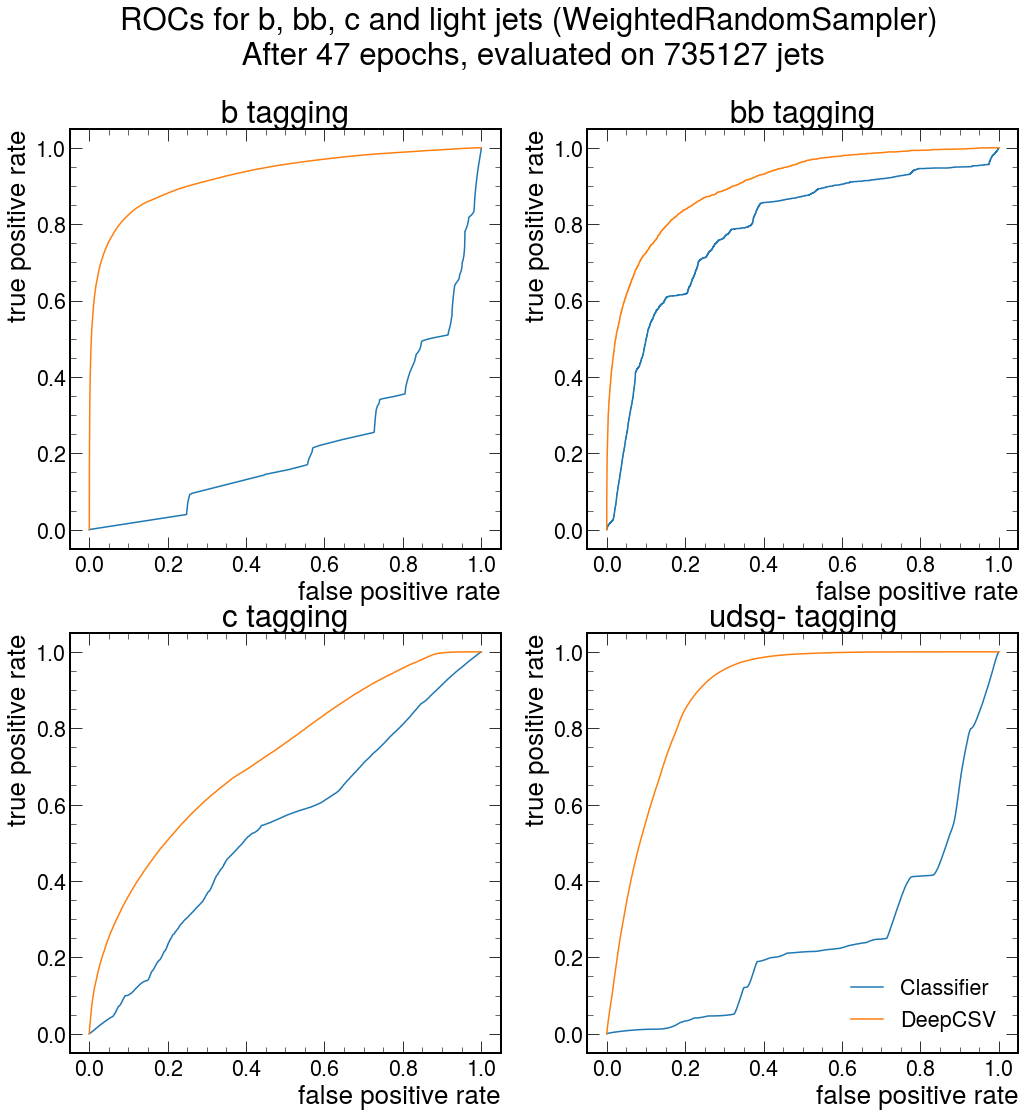

In [289]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (WeightedRandomSampler)\n After {at_epoch} epochs, evaluated on {len_test} jets')
gc.collect()

In [262]:
at_epoch = 150

NUM_DATASETS = 1




allweights = compute_class_weight(
           'balanced',
            classes=np.array([0,1,2,3]), 
            y=torch.cat([torch.load(test_target_file_paths[f]) for f in range(NUM_DATASETS)]).numpy())
class_weights = torch.FloatTensor(allweights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)



model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{at_epoch}_epochs_v10_GPU_weighted_new_{NUM_DATASETS}_datasets_TT.pt', map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

In [263]:
#evaluate network on inputs
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.numpy()
print('predictions done')

jetFlavour = test_targets+1

predictions done


In [264]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [265]:
mostprob = torch.argmax(predsTensor, 1)

In [266]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets, mostprob)
cfm

array([[124871,  33147,   6811,  43209],
       [  1282,   1065,    107,    302],
       [ 22422,   2965,   2379,  38431],
       [ 40576,   5540,   6678, 405342]])

Text(0.5, 0.98, 'Classifier (loss weighting) and DeepCSV outputs\n After 150 epochs, evaluated on 735127 jets')

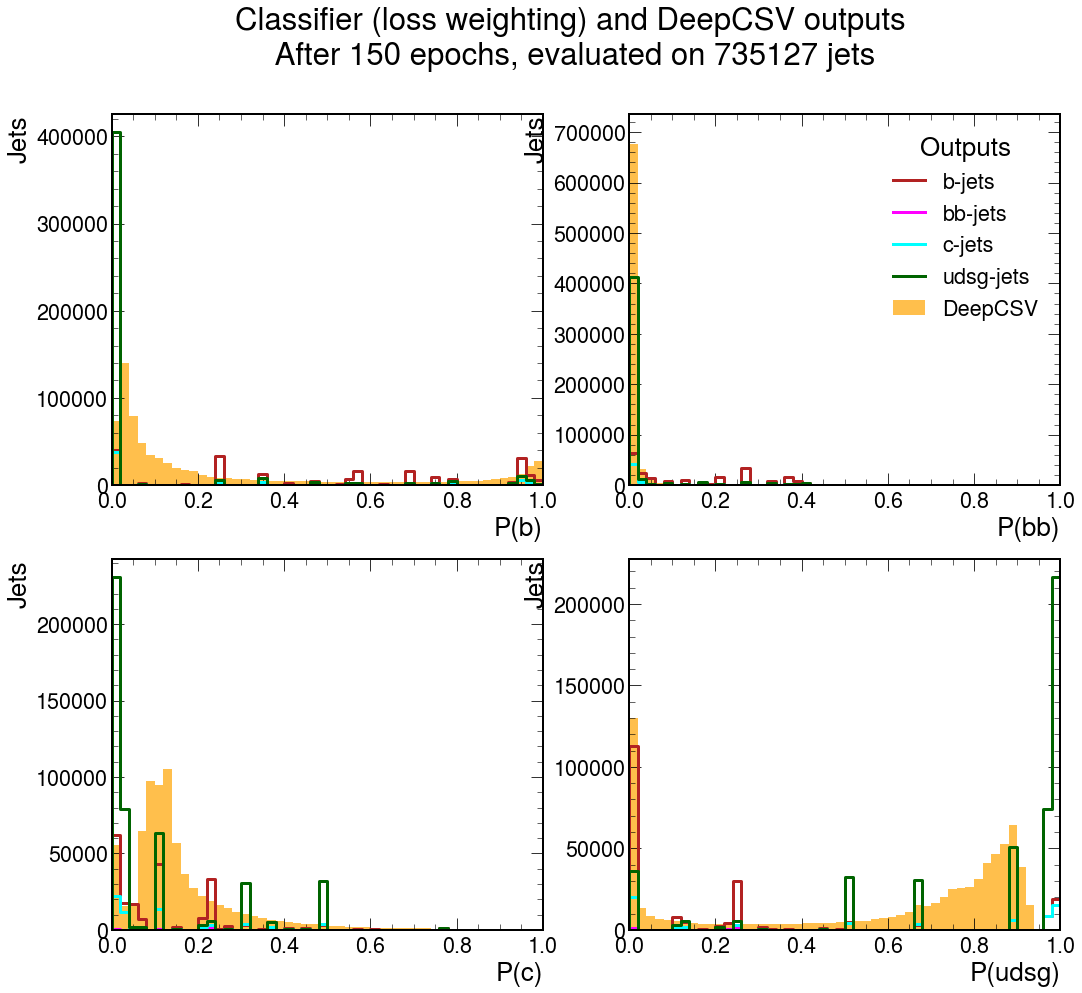

In [267]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (loss weighting) and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.8256408110778123
auc for bb-tagging: 0.8233842272046805
auc for c-tagging: 0.5649368330414131
auc for udsg-tagging: 0.8114217363629753


22075

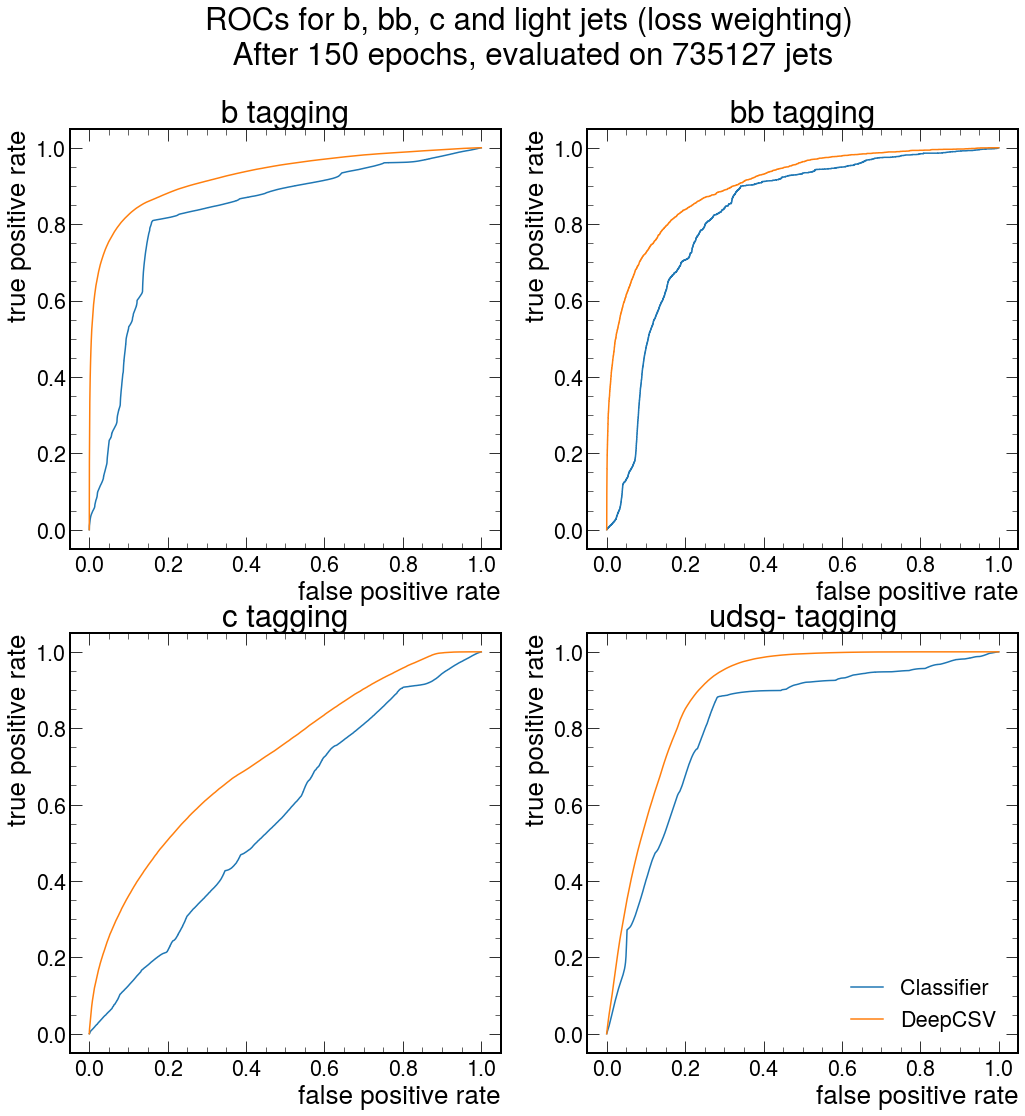

In [268]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (loss weighting)\n After {at_epoch} epochs, evaluated on {len_test} jets')
gc.collect()

In [269]:
at_epoch = 130

NUM_DATASETS = 1



criterion = nn.CrossEntropyLoss()



model = nn.Sequential(nn.Linear(67, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Dropout(0.1),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, 4),
                      nn.Softmax(dim=1))



checkpoint = torch.load(f'/home/um106329/aisafety/new_march_21/models/march2021_{at_epoch}_epochs_v10_GPU_weighted_as_is_{NUM_DATASETS}_datasets_TT.pt', map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)

Sequential(
  (0): Linear(in_features=67, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=100, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): Linear(in_features=100, out_features=4, bias=True)
  (15): Softmax(dim=1)
)

In [270]:
#evaluate network on inputs
model.eval()
predsTensor = model(test_inputs).detach()
predictions = predsTensor.numpy()
print('predictions done')

jetFlavour = test_targets+1

predictions done


In [271]:
np.unique(test_targets.numpy())

array([0., 1., 2., 3.], dtype=float32)

In [272]:
mostprob = torch.argmax(predsTensor, 1)

In [273]:
#cfm = metrics.confusion_matrix(test_targets.view(-1), mostprob.view(-1))
cfm = metrics.confusion_matrix(test_targets, mostprob)
cfm

array([[152499,      0,      0,  55539],
       [  2301,      0,      0,    455],
       [ 23580,      0,      0,  42617],
       [ 42129,      0,      0, 416007]])

Text(0.5, 0.98, 'Classifier (no weighting) and DeepCSV outputs\n After 130 epochs, evaluated on 735127 jets')

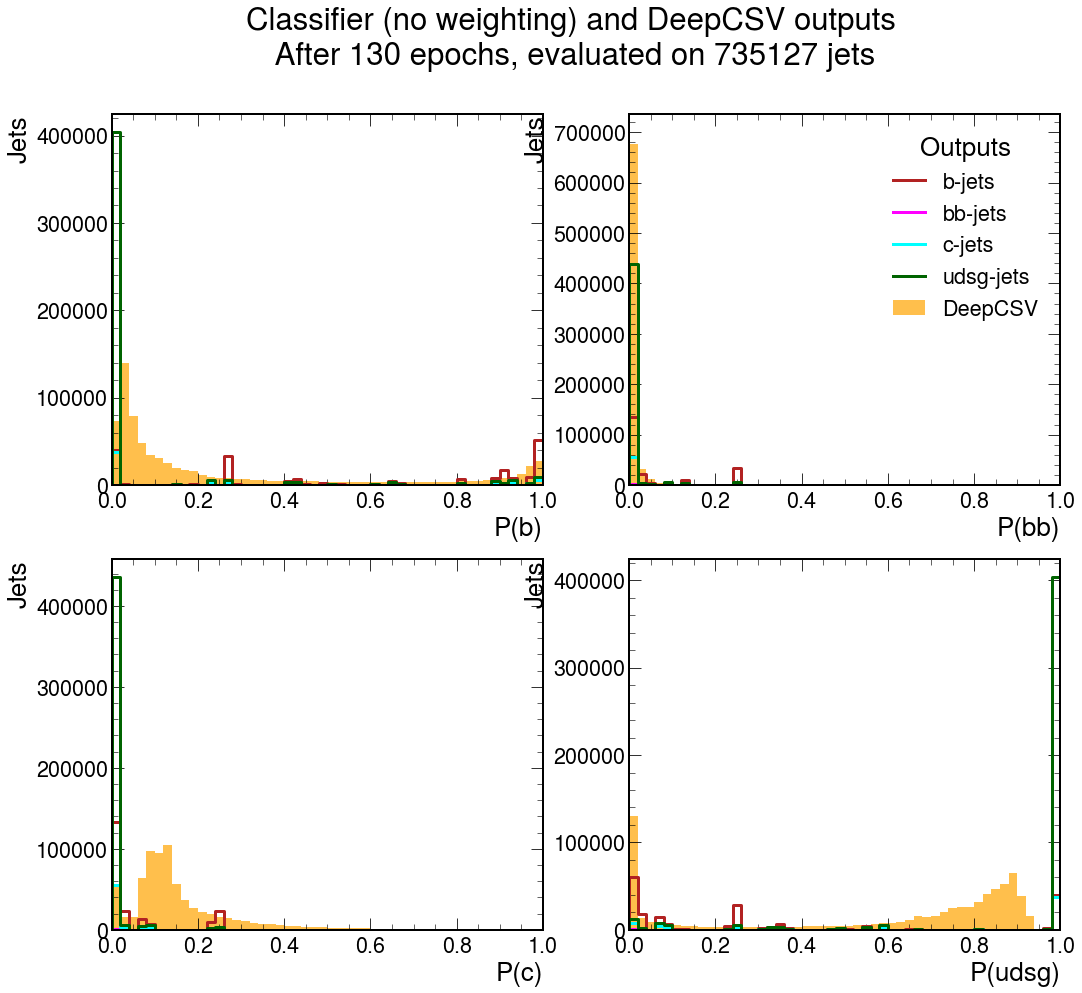

In [274]:
classifierHist = hist.Hist("Jets",
                        hist.Cat("sample","sample name"),
                        hist.Cat("flavour","flavour of the jet"),
                        hist.Bin("probb","P(b)",50,0,1),
                        hist.Bin("probbb","P(bb)",50,0,1),
                        hist.Bin("probc","P(c)",50,0,1),
                        hist.Bin("probudsg","P(udsg)",50,0,1),
                     )

classifierHist.fill(sample="Classifier",flavour='b-jets',probb=predictions[:,0][jetFlavour==1],probbb=predictions[:,1][jetFlavour==1],probc=predictions[:,2][jetFlavour==1],probudsg=predictions[:,3][jetFlavour==1])
classifierHist.fill(sample="Classifier",flavour='bb-jets',probb=predictions[:,0][jetFlavour==2],probbb=predictions[:,1][jetFlavour==2],probc=predictions[:,2][jetFlavour==2],probudsg=predictions[:,3][jetFlavour==2])
classifierHist.fill(sample="Classifier",flavour='c-jets',probb=predictions[:,0][jetFlavour==3],probbb=predictions[:,1][jetFlavour==3],probc=predictions[:,2][jetFlavour==3],probudsg=predictions[:,3][jetFlavour==3])
classifierHist.fill(sample="Classifier",flavour='udsg-jets',probb=predictions[:,0][jetFlavour==4],probbb=predictions[:,1][jetFlavour==4],probc=predictions[:,2][jetFlavour==4],probudsg=predictions[:,3][jetFlavour==4])
classifierHist.fill(sample="DeepCSV",flavour='b-jets',probb=DeepCSV_testset[:,0][jetFlavour==1],probbb=DeepCSV_testset[:,1][jetFlavour==1],probc=DeepCSV_testset[:,2][jetFlavour==1],probudsg=DeepCSV_testset[:,3][jetFlavour==1])
classifierHist.fill(sample="DeepCSV",flavour='bb-jets',probb=DeepCSV_testset[:,0][jetFlavour==2],probbb=DeepCSV_testset[:,1][jetFlavour==2],probc=DeepCSV_testset[:,2][jetFlavour==2],probudsg=DeepCSV_testset[:,3][jetFlavour==2])
classifierHist.fill(sample="DeepCSV",flavour='c-jets',probb=DeepCSV_testset[:,0][jetFlavour==3],probbb=DeepCSV_testset[:,1][jetFlavour==3],probc=DeepCSV_testset[:,2][jetFlavour==3],probudsg=DeepCSV_testset[:,3][jetFlavour==3])
classifierHist.fill(sample="DeepCSV",flavour='udsg-jets',probb=DeepCSV_testset[:,0][jetFlavour==4],probbb=DeepCSV_testset[:,1][jetFlavour==4],probc=DeepCSV_testset[:,2][jetFlavour==4],probudsg=DeepCSV_testset[:,3][jetFlavour==4])



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,15],num=30)
hist.plot1d(classifierHist['Classifier'].sum('sample','probbb','probc','probudsg'),overlay='flavour',ax=ax1,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probc','probudsg'),overlay='flavour',ax=ax2,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probudsg'),overlay='flavour',ax=ax3,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['Classifier'].sum('sample','probb','probbb','probc'),overlay='flavour',ax=ax4,clear=False,line_opts={'color':colorcode,'linewidth':3})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probbb','probc','probudsg'),ax=ax1,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probc','probudsg'),ax=ax2,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probudsg'),ax=ax3,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
hist.plot1d(classifierHist['DeepCSV'].sum('flavour','probb','probbb','probc'),ax=ax4,clear=False,fill_opts={'alpha':.7,'facecolor':'orange'})
ax2.legend(loc='upper right',title='Outputs',ncol=1)
ax1.get_legend().remove(), ax3.get_legend().remove(), ax4.get_legend().remove()
ax2.set_ylim(0, len_test)
fig.suptitle(f'Classifier (no weighting) and DeepCSV outputs\n After {at_epoch} epochs, evaluated on {len_test} jets')


auc for b-tagging: 0.8388668331305392
auc for bb-tagging: 0.8318941396652964
auc for c-tagging: 0.5733086123288956
auc for udsg-tagging: 0.8265881233443607


22075

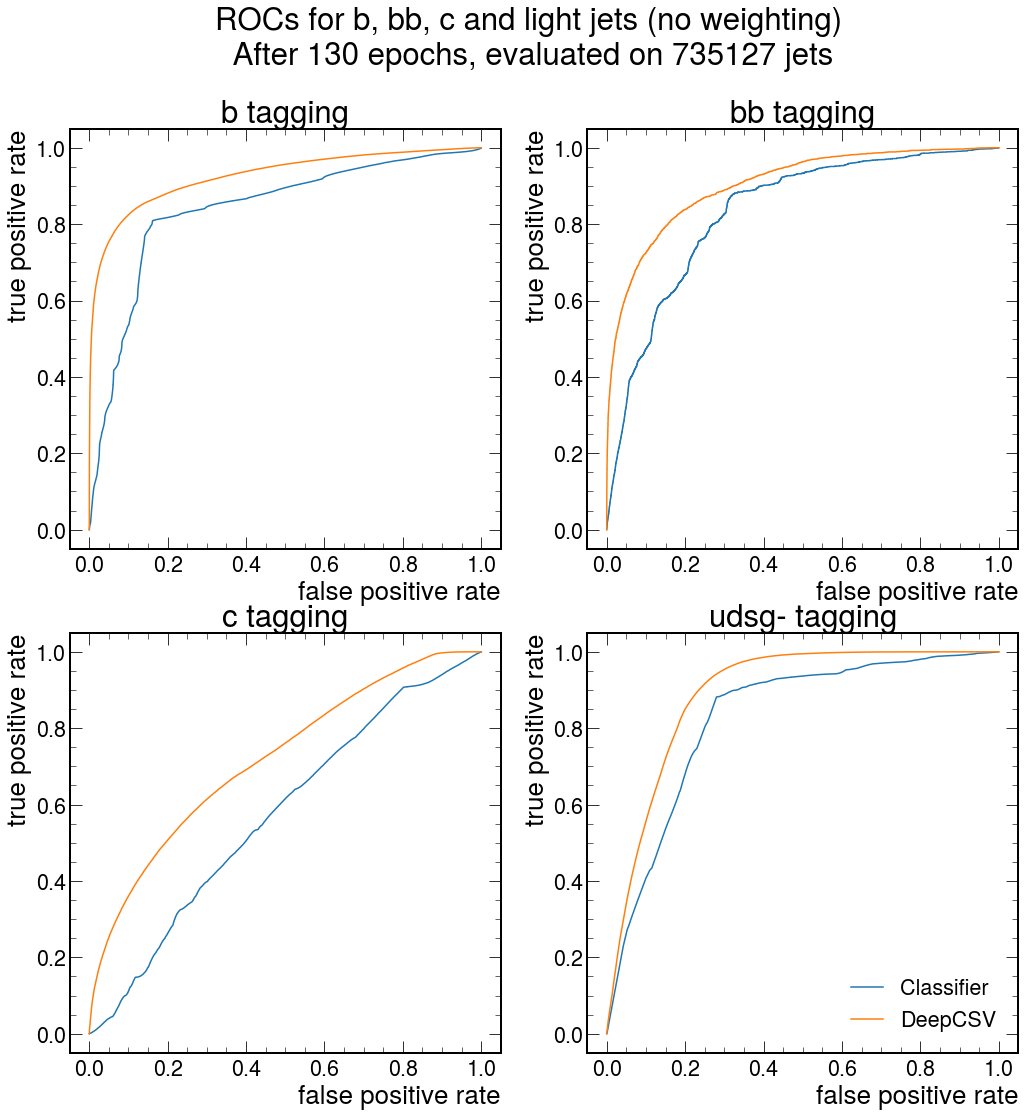

In [275]:
#plot some ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[17,17],num=4)
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],predictions[:,0])
ax1.plot(fpr,tpr)
print(f"auc for b-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==0 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,0])
ax1.plot(fpr,tpr)
ax1.legend(['Classifier','DeepCSV'])
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.set_title('b tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],predictions[:,1])
ax2.plot(fpr,tpr)
print(f"auc for bb-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==1 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,1])
ax2.plot(fpr,tpr)
ax2.legend(['Classifier','DeepCSV'])
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('bb tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],predictions[:,2])
ax3.plot(fpr,tpr)
print(f"auc for c-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==2 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,2])
ax3.plot(fpr,tpr)
ax3.legend(['Classifier','DeepCSV'])
ax3.set_xlabel('false positive rate')
ax3.set_ylabel('true positive rate')
ax3.set_title('c tagging')
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],predictions[:,3])
ax4.plot(fpr,tpr)
print(f"auc for udsg-tagging: {metrics.auc(fpr,tpr)}")
fpr,tpr,thresholds = metrics.roc_curve([(1 if test_targets[i]==3 else 0) for i in range(len(test_targets))],DeepCSV_testset[:,3])
ax4.plot(fpr,tpr)
ax4.legend(['Classifier','DeepCSV'])
ax4.set_xlabel('false positive rate')
ax4.set_ylabel('true positive rate')
ax4.set_title('udsg- tagging')
ax1.get_legend().remove(), ax2.get_legend().remove(), ax3.get_legend().remove()
ax4.legend(['Classifier','DeepCSV'],loc='lower right')
fig.suptitle(f'ROCs for b, bb, c and light jets (no weighting)\n After {at_epoch} epochs, evaluated on {len_test} jets')
gc.collect()